In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from pdb import *
from pathlib import Path
from skimage.io import imread

In [2]:
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.vision.all import *
# from PIL import Images

In [3]:
from nuclei import *

In [4]:
DATA_PATH =  Path('../data/datasciencebowl')
TRAIN_PATH = DATA_PATH/'stage1_train'

In [5]:
torch.cuda.set_device(2)

## Point annotations

In [6]:
pt_annotations = get_pt_annotations(DATA_PATH)

## Create gaussian mask

In [7]:

def get_x(idx):
    return TRAIN_PATH/images[idx]

def get_y(idx, r=14, sz=256):
    w,h = PILImage.create(TRAIN_PATH/images[idx]).shape
#     r = int(r * w / sz)
    mask = np.zeros((w,h))
    for x,y in points[idx]:
        draw_umich_gaussian(mask, (x,y), r)
    return PILMask.create(mask.astype(float))

In [8]:
images, points = zip(*pt_annotations)

In [9]:
idxs = range(len(images))
train_idxs = [idx for idx,image in enumerate(images) if image.stem not in set(VAL_IMAGE_IDS)]
valid_idxs = [idx for idx,image in enumerate(images) if image.stem in set(VAL_IMAGE_IDS)]

In [10]:
tfms = [[get_x, PILImage.create], [get_y]]
dsets = Datasets(items=idxs, tfms=tfms, splits=[train_idxs, valid_idxs])

<AxesSubplot:>

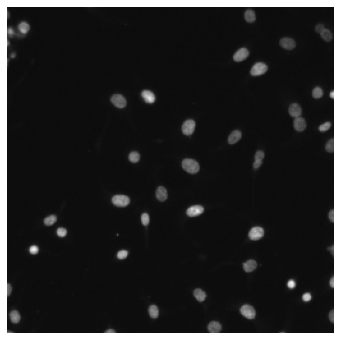

In [11]:
dsets[35][0].show(figsize=(6,6))

In [12]:
import matplotlib as mpl
cmap = mpl.cm.Blues
cmap.set_under('k', 0.0)

from matplotlib.colors import ListedColormap
# Choose colormap
cmap = mpl.cm.Greens
# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
my_cmap = ListedColormap(my_cmap)

<ipython-input-12-8367bbe872f2>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  cmap.set_under('k', 0.0)


In [13]:
idx = 21

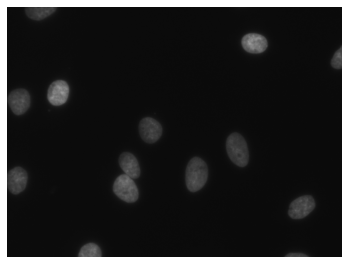

In [14]:
ctx = dsets[idx][0].show(figsize=(6,6), alpha=1.0)
dsets[idx][1].show(ctx=ctx, cmap=my_cmap, alpha=0.0)
idx += 1

In [15]:
import matplotlib as mpl
cmap = mpl.cm.tab20
cmap.set_under('k', 0.0)

<ipython-input-15-fb3a472f6168>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("tab20"))
  cmap.set_under('k', 0.0)


In [16]:
# currently augmentation transform screws with the padding
batch_tfms = [*aug_transforms(max_zoom=1.2, max_rotate=45, flip_vert=True), Normalize.from_stats(*imagenet_stats)]

sz_mthd = RandomCrop
# sz_mthd = Resize

dls = dsets.dataloaders(bs=32, after_item=[sz_mthd(256), ToTensor, IntToFloatTensor], after_batch=batch_tfms, num_workers=8)
dls.c = 1

In [17]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 256, 256]))

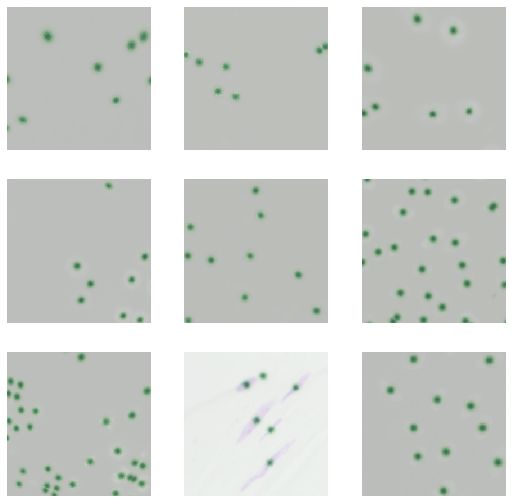

In [18]:
dls.show_batch(cmap="Greens", alpha=0.5)

## Learner

In [19]:
def acc_nuclei(input, target, thresh = 0.5):
    target = target[:, None]
    mask = target > thresh
    acc = (input[mask] > thresh) == (target[mask] > thresh)
    return acc.float().mean()
#     return (input[mask]==target[mask]).float().mean()

In [20]:

def _neg_loss(pred, gt, eps=1e-12):
    ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
    Arguments:
      pred (batch x c x h x w)
      gt_regr (batch x c x h x w)
    '''
    
    pos_inds = gt.gt(0.99).float()
    neg_inds = gt.lt(0.99).float()

    neg_weights = torch.pow(1 - gt, 4)

    loss = 0

    pos_loss = torch.log(pred + eps) * torch.pow(1 - pred, 2) * pos_inds
    neg_loss = torch.log(1 - pred + eps) * torch.pow(pred, 2) * neg_weights * neg_inds

    num_pos  = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    if num_pos == 0: 
        loss = loss - neg_loss
    else:
        loss = loss - (pos_loss + neg_loss) / num_pos
    return loss

class FocalLoss(nn.Module):
    '''nn.Module warpper for focal loss'''
    def __init__(self):
        super().__init__()
        self.neg_loss = _neg_loss

    def forward(self, out, target):
        
        bs = target.shape[0]
        loss = self.neg_loss(torch.sigmoid(out), target.data[:, None])
        return loss
    
    def activation(self, x): return torch.sigmoid(x)

In [21]:
loss_func = FocalLoss()
metrics=acc_nuclei

In [23]:
learn = unet_learner(dls, resnet34, metrics=metrics, loss_func=loss_func, pretrained=True)
learn.path = DATA_PATH

In [24]:
learn.unfreeze()
learn.fit_one_cycle(60, 1e-3, wd=1e-4)

epoch,train_loss,valid_loss,acc_nuclei,time
0,11.057428,3.960158,0.000000,00:15
1,6.522630,2.780508,0.000000,00:10
2,4.598470,1.855898,0.000221,00:10
3,3.420908,1.781012,0.011199,00:10
4,2.709150,1.378643,0.003977,00:10
5,2.226253,1.082984,0.010100,00:10
6,1.857307,0.882164,0.034047,00:10
7,1.548507,0.851672,0.042377,00:10
8,1.326697,0.884689,0.060746,00:10
9,1.169763,0.817059,0.086704,00:10


In [25]:
learn.save('centernet-heatmap-resnet34')

Path('models/centernet-heatmap-resnet34-rerun_pretrained.pth')

In [26]:
learn.fit_one_cycle(60, 1e-4, wd=1e-4)

epoch,train_loss,valid_loss,acc_nuclei,time
0,0.460488,0.553726,0.073292,00:11
1,0.462601,0.550960,0.074064,00:11
2,0.464775,0.551128,0.073192,00:11
3,0.462016,0.555000,0.076560,00:11
4,0.466088,0.559940,0.077954,00:11
5,0.470094,0.557533,0.066758,00:11
6,0.472010,0.569234,0.068448,00:11
7,0.469754,0.548162,0.067217,00:11
8,0.469203,0.545750,0.075081,00:11
9,0.471903,0.564079,0.076278,00:11


In [27]:
learn.save('centernet-heatmap-resnet34-2')

Path('models/centernet-heatmap-resnet34-rerun_pretrained_2.pth')

In [24]:
learn.load('centernet-heatmap-resnet34-2')

In [25]:
preds, lbls = learn.get_preds()
preds = preds.detach().cpu().numpy()
lbls = lbls[:, None].detach().cpu().numpy()

In [26]:
def max_px(box, targ):
    targ = targ[0]
    m = np.zeros_like(targ)
#     x,y,w,h = box
    y,x,h,w = box
    m[x:x+w,y:y+h] = 1
    ind = np.unravel_index(np.argmax(targ*m, axis=None), targ.shape)
#     if ind == (0,0): pdb.set_trace()
    return ind

def ed(pt1, pt2):
    (xA,yA), (xB,yB) = pt1, pt2
    return ((xB-xA)**2 + (yB-yA)**2)**0.5

def calc_pr_area(lbls, preds, pmaxs, min_area=8, max_dist=5, iou_thresh=0.1, score_thresh=0.3):
    tps = []
    fps = []
    scores = []
    n_gts = []
    for lbl,pred,pmax in zip(lbls,preds,pmaxs):
        contours,hierarchy = cv2.findContours(pmax.max(0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        pboxes = [cv2.boundingRect(cnt) for cnt in contours if cv2.contourArea(cnt) >= min_area]
        pboxes = [max_px(pbox, pred) for pbox in pboxes]
        pboxes = list(sorted(pboxes, key=lambda x: pred[0][x], reverse=True)) # sort by scores

        contours,hierarchy = cv2.findContours((lbl>=0.9).max(0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        lboxes = [max_px(cv2.boundingRect(cnt), lbl) for cnt in contours]
                
        detected = []
        dists = []
        for pb in pboxes:
            calc = [(ed(lb, pb), lb) for lb in lboxes if lb not in detected]
            if len(calc) == 0:
                dists.append(1e10)
            else:
                dist, lb = min(calc)
                detected.append(lb)
                dists.append(dist)
        tp = (np.array(dists) < max_dist)
        fp = ~tp
        s = np.array([pred[0, pb[0],pb[1]] for pb in pboxes])
            
        
        n_gts.append(len(lboxes))
        tps.extend(tp.astype(np.uint8).tolist())
        fps.extend(fp.astype(np.uint8).tolist())
        scores.extend(s.tolist())
        
    res = sorted(zip(scores, tps, fps), key=lambda x: x[0], reverse=True)
    res = np.array(res)
    if len(res) == 0: res = np.zeros((1, 3))
    tp = res[:,1].cumsum(0)
    fp = res[:,2].cumsum(0)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / sum(n_gts)
    return precision, recall

for dist in [2, 5, 10]:
    aps = []
    for s in [1, 2, 3, 5]:
        for sz in [0,1,2]:
            score_thresh = s/10
            pmaxs = (preds > score_thresh).astype(np.uint8)

            precision, recall = calc_pr_area(lbls, preds, pmaxs, max_dist=dist, min_area=sz, score_thresh=score_thresh)
            aps.append((compute_ap(precision, recall),score_thresh,sz))
    print(dist, max(aps))

2 (0.5768840012405767, 0.3, 0)
5 (0.7807657691865676, 0.2, 0)
10 (0.8327425245394117, 0.2, 0)


In [35]:

for dist in [2, 5, 10]:
    aps = []
    for s in [1, 2, 3, 5]:
        for sz in [0,1,2]:
            score_thresh = s/10
            pmaxs = (preds > score_thresh).astype(np.uint8)

            precision, recall = calc_pr_area(lbls, preds, pmaxs, max_dist=dist, min_area=sz, score_thresh=score_thresh)
            F1 = (2 * (precision * recall) / (precision + recall))[-1]
            aps.append((compute_ap(precision, recall),score_thresh,sz,F1))
    print(dist, max(aps))

2 (0.5768840012405767, 0.3, 0, 0.6621244967461688)
5 (0.7807657691865676, 0.2, 0, 0.8150786583531757)
10 (0.8327425245394117, 0.2, 0, 0.8613831997599841)


<AxesSubplot:>

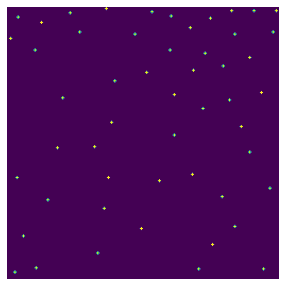

In [28]:
idx = 5
PILImage.create(lbls[idx, 0] > 0.97).show()

<AxesSubplot:>

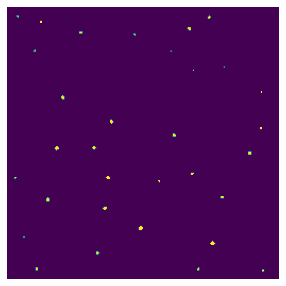

In [29]:
PILImage.create(preds[idx, 0] > 0.7).show()

In [30]:
import matplotlib as mpl
cmap = mpl.cm.Greens
# cmap = mpl.cm.Dark2
cmap.set_under('k', 0.0)
# cmap.set_bad('k', 0.0)
# mask.show(cmap=cmap, vmin=1, alpha=1.0)

<ipython-input-30-39d84c6f035d>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greens"))
  cmap.set_under('k', 0.0)


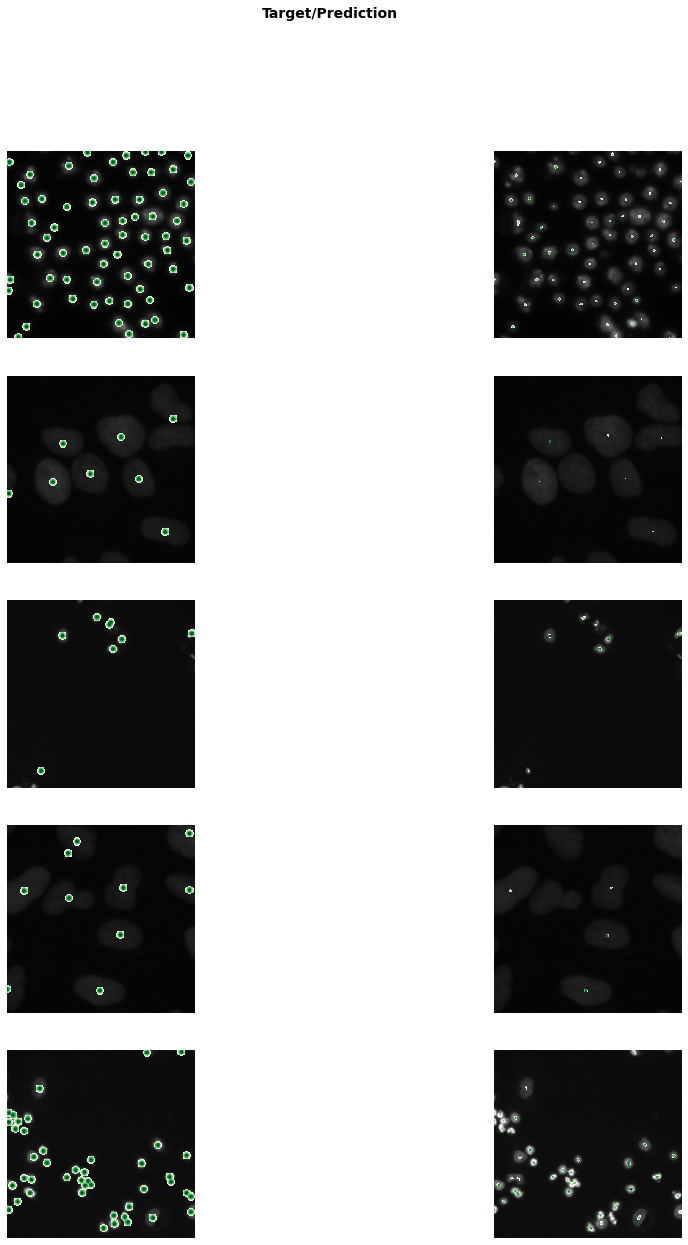

In [31]:
learn.show_results(figsize=(16,20), cmap=cmap, vmin=0.5, max_n=100, alpha=1.0, shuffle=True)